# Accelerated MuZero in Jax

In [2]:
import dataclasses
import functools
from __future__ import annotations
from typing import Callable

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import matplotlib.pyplot as plt

import chex
import flax
import flax.linen as nn
import mctx
import optax

from flax.training import train_state
from tqdm import tqdm

/usr/local/Caskroom/miniforge/base/envs/jax/lib/python3.11/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/usr/local/Caskroom/miniforge/base/envs/jax/lib/python3.11/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/usr/local/Caskroom/miniforge/base/envs/jax/lib/python3.11/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Gomoku

In [3]:
@chex.dataclass(frozen=True)
class Gomoku:
  rows: int = 10
  cols: int = 10
  n: int = 3

  def action_size(self) -> int:
    return self.rows * self.cols

  def reset(self) -> chex.Array:
    return jnp.zeros((self.rows, self.cols))

  def next_player(self, player: int) -> int:
    return -player

  @jax.jit
  def valid_moves(self, state: chex.Array) -> chex.Array:
    return state.reshape(-1) == 0

  @functools.partial(jax.jit, static_argnums=(0,))
  def step(self, state: chex.Array, action: int, player: int) -> chex.ArrayTree:
    state = state.at[action // self.cols, action % self.cols].set(player)
    draw = jnp.sum(self.valid_moves(state)) == 0
    is_win = self.is_win(state, player)
    reward = is_win.astype(jnp.int32) * (1 - draw.astype(jnp.int32)) * player
    terminal = jnp.logical_or(is_win, draw)
    return state, reward, terminal

  @functools.partial(jax.jit, static_argnums=(0,))
  def is_win(self, state: chex.Array, curr_player: int) -> chex.Array:
    p_mask = state == curr_player
    horizonal_kernel = jnp.ones((1, self.n))
    vertical_kernel = jnp.ones((self.n, 1))
    diagonal_kernel_1 = jnp.eye(self.n)
    diagonal_kernel_2 = jnp.flip(jnp.eye(self.n), axis=0)

    max_counts = jnp.stack([
        jnp.max(jsp.signal.convolve2d(p_mask, horizonal_kernel, mode="valid")),
        jnp.max(jsp.signal.convolve2d(p_mask, vertical_kernel, mode="valid")),
        jnp.max(jsp.signal.convolve2d(p_mask, diagonal_kernel_1, mode="valid")),
        jnp.max(jsp.signal.convolve2d(p_mask, diagonal_kernel_2, mode="valid")),
    ])
    return jnp.any(max_counts >= self.n)

  @jax.jit
  def canonical(self, state: chex.Array) -> chex.Array:
    return jnp.stack([state == -1, state == 0, state == 1]).astype(jnp.float32)

  def inverse_canonical(self, canonical: chex.Array) -> chex.Array:
    opponent = canonical[0].astype(dtype=jnp.bool_)
    empty = canonical[1].astype(dtype=jnp.bool_)
    player = canonical[2].astype(dtype=jnp.bool_)
    return jnp.where(empty, 0, jnp.where(player, 1, -1))

  def render(self, state: chex.Array) -> None:
    plt.imshow(state, cmap="gray")
    plt.show()

## Neural Network

In [4]:
class ConvolutionalBlock(nn.Module):
  num_hidden: int

  @nn.compact
  def __call__(self, x, train: bool = False):
    y = nn.Conv(self.num_hidden, kernel_size=(3, 3))(x)
    y = nn.BatchNorm(use_running_average=not train)(y)
    return nn.relu(y)


class ResidualBlock(nn.Module):
  num_hidden: int

  @nn.compact
  def __call__(self, x, train: bool = False):
    y = nn.Conv(self.num_hidden, kernel_size=(3, 3))(x)
    y = nn.BatchNorm(use_running_average=not train)(y)
    y = nn.relu(y)
    y = nn.Conv(self.num_hidden, kernel_size=(3, 3))(x)
    y = nn.BatchNorm(use_running_average=not train)(y)
    return nn.relu(x + y)


class PolicyValueNet(nn.Module):
  num_blocks: int
  action_size: int
  num_hidden: int = 64
  num_hidden_policy: int = 32
  num_hidden_value: int = 3

  @nn.compact
  def __call__(self, x, train: bool = False) -> tuple[chex.Array, chex.Array]:
    y = ConvolutionalBlock(self.num_hidden)(x, train=train)
    for _ in range(self.num_blocks):
      y = ResidualBlock(self.num_hidden)(y, train=train)

    policy = ConvolutionalBlock(self.num_hidden_policy)(y, train=train)
    policy = policy.reshape(policy.shape[0], -1)
    policy = nn.Dense(self.action_size)(policy)
    policy = nn.softmax(policy)

    value = ConvolutionalBlock(self.num_hidden_value)(y, train=train)
    value = value.reshape(value.shape[0], -1)
    value = nn.Dense(1)(value)
    value = nn.tanh(value).squeeze(-1)

    return policy, value

  def build_inference_fn(
      self, variables: chex.ArrayTree
  ) -> Callable[chex.Array, tuple[chex.Array, chex.Array]]:
    @jax.jit
    def infer(batch):
      return self.apply(variables, batch, train=False)

    return infer

In [5]:
class TrainState(train_state.TrainState):
  batch_stats: chex.ArrayTree


@jax.jit
def train_step(
    train_state: TrainState,
    batch: tuple[chex.Array, chex.Array, chex.Array],
) -> tuple[float, chex.ArrayTree]:
  def loss_fn(params):
    inputs, policy_targets, value_targets = batch
    variables = {"params": params, "batch_stats": train_state.batch_stats}
    (policy_logits, value), updates = model.apply(
        variables, inputs, train=True, mutable=["batch_stats"]
    )
    policy_loss = optax.softmax_cross_entropy(policy_logits, policy_targets)
    value_loss = optax.l2_loss(value - value_targets)
    policy_loss = jnp.mean(policy_loss)
    value_loss = jnp.mean(value_loss)
    loss = policy_loss + value_loss
    return loss, (policy_loss, value_loss, updates)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, aux), grads = grad_fn(train_state.params)
  train_state = train_state.apply_gradients(grads=grads)

  policy_loss, value_loss, updates = aux
  train_state = train_state.replace(batch_stats=updates["batch_stats"])

  metrics = {
      "loss": loss,
      "policy_loss": policy_loss,
      "value_loss": value_loss,
  }

  return train_state, metrics

In [6]:
game = Gomoku()
x = jax.lax.expand_dims(game.canonical(game.reset()), [0])
x.shape

(1, 3, 10, 10)

In [7]:
model = PolicyValueNet(
    num_hidden=32, num_blocks=2, action_size=game.action_size()
)
variables = model.init(jax.random.PRNGKey(0), x)
inference_fn = model.build_inference_fn(variables)

In [8]:
inference_fn(x)[0].shape

(1, 100)

## MCTS

In [9]:
@chex.dataclass(frozen=True)
class Config:
  iterations: int = 10
  mcts_simulations: int = 100
  batch_size: int = 32
  self_play_games: int = 500
  self_play_unroll_games: int = 100
  num_epochs: int = 10
  # C: float


@chex.dataclass(frozen=True)
class MCTS:
  env: Gomoku
  config: Config

  @functools.partial(jax.jit, static_argnums=(0, 1))
  def search(
      self,
      inference_fn: Callable[chex.Array, tuple[chex.Array, chex.Array]],
      states: chex.Array,
      players: chex.Array,
      prng: chex.PRNGKey,
  ) -> mctx.PolicyOutput:
    inputs = jax.vmap(self.env.canonical)(states)
    prior_logits, value = inference_fn(inputs)
    root = mctx.RootFnOutput(
        prior_logits=prior_logits,
        value=value,
        embedding=(states, players),
    )

    valid_moves = jax.vmap(self.env.valid_moves)(states)

    policy_output = mctx.muzero_policy(
        params={},  # Inference function will apply correct params.
        rng_key=prng,
        root=root,
        recurrent_fn=self.build_recurrent_fn(inference_fn),
        num_simulations=self.config.mcts_simulations,
        invalid_actions=~valid_moves,
    )
    return policy_output

  def build_recurrent_fn(self, inference_fn) -> mctx.RecurrentFn:
    batch_step = jax.vmap(self.env.step, in_axes=(0, 0, 0))
    batch_canonical = jax.vmap(self.env.canonical)
    batch_next_player = jax.vmap(self.env.next_player)

    def recurrent_fn(params, rng_key, actions, embedding):
      del params
      del rng_key

      prior_states, players = embedding
      states, rewards, terminals = batch_step(prior_states, actions, players)
      next_players = batch_next_player(players)
      inputs = batch_canonical(states)
      policy, value = inference_fn(inputs)
      recurrent_fn_output = mctx.RecurrentFnOutput(
          reward=rewards,
          discount=terminals.astype(jnp.int32) - 1,
          prior_logits=policy,
          value=value,
      )
      return recurrent_fn_output, (states, next_players)

    return recurrent_fn


game = Gomoku(rows=10, cols=10, n=4)
config = Config()
prng = jax.random.PRNGKey(0)
param_key, mcts_key = jax.random.split(prng)

init_states = jax.vmap(game.reset, axis_size=config.batch_size)()
init_players = jnp.ones(config.batch_size)
init_canonical = jax.vmap(game.canonical)(init_states)

model = PolicyValueNet(
    num_hidden=32, num_blocks=2, action_size=game.action_size()
)
variables = model.init(param_key, init_canonical)
inference_fn = model.build_inference_fn(variables)

mcts = MCTS(env=game, config=config)
policy_output = mcts.search(inference_fn, init_states, init_players, mcts_key)
jax.tree_map(lambda x: x.shape, policy_output).items()

ItemsView(PolicyOutput(action=(32,), action_weights=(32, 100), search_tree=Tree(node_visits=(32, 101), raw_values=(32, 101), node_values=(32, 101), parents=(32, 101), action_from_parent=(32, 101), children_index=(32, 101, 100), children_prior_logits=(32, 101, 100), children_visits=(32, 101, 100), children_rewards=(32, 101, 100), children_discounts=(32, 101, 100), children_values=(32, 101, 100), embeddings=((32, 101, 10, 10), (32, 101)), root_invalid_actions=(32, 100), extra_data=None)))

## MuZero

In [70]:
class MuZero:

  def __init__(
      self,
      env: Gomoku,
      config: Config,
      model: PolicyValueNet,
      optimizer: optax.GradientTransformation,
      prng: chex.PRNGKey,
  ):
    self.env = env
    self.config = config
    self.model = model
    self.optimizer = optimizer
    self.mcts = MCTS(env=self.env, config=self.config)

    init_states = jax.vmap(self.env.reset, axis_size=self.config.batch_size)()
    init_canonical = jax.vmap(game.canonical)(init_states)
    self.variables = self.model.init(prng, init_canonical)

  @functools.partial(jax.jit, static_argnums=(0,))
  def vectorized_self_play(self, prng: chex.PRNGKey):
    inference_fn = self.model.build_inference_fn(self.variables)

    batch_step = jax.vmap(self.env.step, in_axes=(0, 0, 0))
    batch_canonical = jax.vmap(self.env.canonical)
    batch_next_player = jax.vmap(self.env.next_player)
    batch_reset = jax.vmap(self.env.reset, axis_size=self.config.batch_size)
    player_reset = lambda: jnp.ones(self.config.batch_size)
    terminal_reset = lambda: jnp.zeros(self.config.batch_size).astype(jnp.bool_)

    def game_loop(loop_state, _):
      states, players, terminals, rng_key = loop_state
      rng_key, subkey = jax.random.split(rng_key)

      # Reset states that terminated in the previous step
      padded_terminals = jax.lax.expand_dims(terminals, [-2, -1])
      states = jnp.where(padded_terminals, batch_reset(), states)
      players = jnp.where(terminals, player_reset(), players)

      # MCTS
      policy_output = self.mcts.search(inference_fn, states, players, subkey)
      actions = policy_output.action
      action_probs = policy_output.action_weights

      # Track canonical states for memory buffer
      canonical_states = batch_canonical(states)

      # Batched step
      states, rewards, terminals = batch_step(states, actions, players)
      players = batch_next_player(players)

      loop_state = states, players, terminals, rng_key
      outputs = canonical_states, action_probs, rewards, terminals
      return loop_state, outputs

    loop_state = batch_reset(), player_reset(), terminal_reset(), prng
    canonical_states, action_probs, rewards, terminals = jax.lax.scan(
        game_loop, loop_state, None, length=self.config.self_play_unroll_games
    )[1]
    game_count = jnp.sum(terminals).squeeze().astype(jnp.int32)

    def win_scan_fn(accum, x):
      reward, terminal = x
      new_accum = jnp.where(terminal, reward, accum)
      return new_accum, new_accum

    carry = jnp.zeros(self.config.batch_size)
    winners = jax.lax.scan(
        win_scan_fn, carry, (rewards, terminals), reverse=True
    )[1]
    cumsum = jnp.flip(jnp.cumsum(jnp.flip(terminals, axis=0), axis=0), axis=0)
    valid_mask = cumsum > 0

    flatten = lambda x: x.reshape((-1,) + x.shape[2:])
    canonical, action_probs, winners, valid_mask = jax.tree_map(
        flatten, (canonical_states, action_probs, winners, valid_mask)
    )

    return (canonical, action_probs, winners), valid_mask, game_count

  def self_play(self, prng: chex.PRNGKey) -> chex.ArrayTree:
    # Batched self-play until the target number of games is reached
    memory = []
    net_game_count = 0
    pbar = tqdm(total=self.config.self_play_games)
    while net_game_count < self.config.self_play_games:
      prng, mcts_key = jax.random.split(prng)
      entries, valid_mask, game_count = self.vectorized_self_play(mcts_key)
      entries = jax.tree_map(lambda x: x[valid_mask], entries)
      memory.append(entries)

      # Cast to resolve async dispatch issues
      game_count = np.array(game_count)
      pbar.update(game_count)
      net_game_count += game_count
    pbar.close()

    # Return a tuple of states, policy targets, value targets
    return tuple(map(jnp.concatenate, zip(*memory)))

  def learn(self, prng: chex.PRNGKey):
    train_state = TrainState.create(
        apply_fn=self.model.apply,
        params=self.variables["params"],
        tx=self.optimizer,
        batch_stats=self.variables["batch_stats"],
    )

    overall_metrics = []
    for i in range(self.config.iterations):
      print(f"Iteration {i + 1}:")

      # Self-play to generate training data
      print("Self Play...")
      memory = self.self_play(prng)

      # Train the Policy-Value network
      print("Training...")
      b = self.config.batch_size
      N = memory[0].shape[0]
      for _ in range(self.config.num_epochs):
        epoch_metrics = []
        for i in tqdm(range(N // b)):
          prng, sample_key = jax.random.split(prng)
          sample_idxs = jax.random.randint(sample_key, (b,), 0, N)
          batch = jax.tree_map(lambda x: x[sample_idxs], memory)
          train_state, metrics = train_step(train_state, batch)
          epoch_metrics.append(metrics)

        print(f"Epoch Loss: {np.mean([m['loss'] for m in epoch_metrics])}")

        overall_metrics.extend(epoch_metrics)

    return train_state, overall_metrics

  def optimal_policy(self, state: chex.Array, player: int, prng: chex.PRNGKey):
    inference_fn = self.model.build_inference_fn(self.variables)
    pad_size = self.config.batch_size - 1
    states = jnp.stack([state] + [self.env.reset()] * pad_size)
    players = jnp.stack([player] + [1] * pad_size)
    policy_output = self.mcts.search(inference_fn, states, players, prng)
    return policy_output.action_weights[0]

In [46]:
init_key, learn_key = jax.random.split(jax.random.PRNGKey(0))
env = Gomoku(rows=3, cols=3, n=3)
muzero = MuZero(
    env=env,
    config=Config(
        iterations=3,
        self_play_games=500,
        mcts_simulations=60,
        batch_size=32,
        self_play_unroll_games=60,
        num_epochs=5,
    ),
    model=PolicyValueNet(num_blocks=4, action_size=env.action_size()),
    optimizer=optax.adamw(learning_rate=0.001),
    prng=init_key,
)
train_state, metrics = muzero.learn(learn_key)

Iteration 1:
Self Play...


264it [00:24, 10.98it/s]               


Training...


100%|██████████| 56/56 [00:05<00:00, 10.29it/s]


Epoch Loss: 2.288823366165161


100%|██████████| 56/56 [00:01<00:00, 54.59it/s]


Epoch Loss: 2.1922411918640137


100%|██████████| 56/56 [00:01<00:00, 46.69it/s]


Epoch Loss: 2.180494546890259


100%|██████████| 56/56 [00:01<00:00, 50.76it/s]


Epoch Loss: 2.1507201194763184


100%|██████████| 56/56 [00:01<00:00, 51.37it/s]


Epoch Loss: 2.1273353099823
Iteration 2:
Self Play...


268it [00:21, 12.73it/s]               


Training...


100%|██████████| 57/57 [00:01<00:00, 43.24it/s]


Epoch Loss: 2.1965525150299072


100%|██████████| 57/57 [00:01<00:00, 50.88it/s]


Epoch Loss: 2.132498264312744


100%|██████████| 57/57 [00:01<00:00, 53.33it/s]


Epoch Loss: 2.132735252380371


100%|██████████| 57/57 [00:01<00:00, 53.31it/s]


Epoch Loss: 2.1309123039245605


100%|██████████| 57/57 [00:01<00:00, 55.93it/s]


Epoch Loss: 2.108787775039673
Iteration 3:
Self Play...


271it [00:20, 13.31it/s]               


Training...


100%|██████████| 57/57 [00:01<00:00, 49.62it/s]


Epoch Loss: 2.158635139465332


100%|██████████| 57/57 [00:01<00:00, 54.70it/s]


Epoch Loss: 2.113091468811035


100%|██████████| 57/57 [00:00<00:00, 58.94it/s]


Epoch Loss: 2.123042345046997


100%|██████████| 57/57 [00:01<00:00, 53.87it/s]


Epoch Loss: 2.084272623062134


100%|██████████| 57/57 [00:01<00:00, 51.80it/s]

Epoch Loss: 2.061075210571289


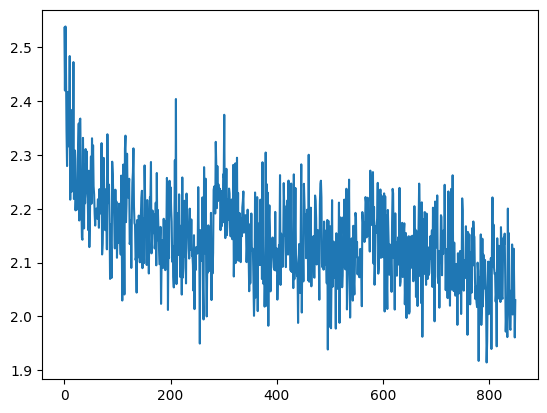

In [47]:
plt.plot([m["loss"] for m in metrics])
plt.show()

In [73]:
state = env.reset()
terminal = False
player = 1
prng = jax.random.PRNGKey(0)

while not terminal:
  print(state)

  if player == 1:
    valid_moves = np.arange(env.action_size())[env.valid_moves(state)]
    print(f"Valid Moves: {valid_moves}")
    action = int(input(f"Player {player}:"))
    if action not in valid_moves:
      print("Invalid Move.")
      continue

  else:
    policy = MuZero.optimal_policy(muzero, state, player, prng)
    action = np.argmax(policy)

  state, reward, terminal = env.step(state, action, player)
  potential_winner = player
  player = -player

print(state)
if reward > 0:
  print(f"{potential_winner} won!")
else:
  print("Draw!")

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Valid Moves: [0 1 2 3 4 5 6 7 8]
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 1.  0. -1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
Valid Moves: [1 3 4 5 6 7 8]
Invalid Move.
[[ 1.  0. -1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
Valid Moves: [1 3 4 5 6 7 8]
[[ 1.  0. -1.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
[[ 1.  0. -1.]
 [ 0.  1.  0.]
 [ 0. -1.  0.]]
Valid Moves: [1 3 5 6 8]
[[ 1.  1. -1.]
 [ 0.  1.  0.]
 [ 0. -1.  0.]]
[[ 1.  1. -1.]
 [ 0.  1.  0.]
 [ 0. -1. -1.]]
Valid Moves: [3 5 6]


ValueError: invalid literal for int() with base 10: ''